In [1]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import array_to_latex as a2l

"""
Own packages
"""

from codelib.population_parameters import calculate_mean, calculate_cov_mat, corr_to_cov_matrix, project_logreturns_dist_params, calculate_mu_linear_returns, calculate_cov_mat_linear_returns, cov_to_corr_and_vols
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio
from codelib.portfolio_optimizers import calculate_max_sharpe_portfolio, calculate_min_var_portfolio

# Afkastforventninger.dk
afkastforventinger 1H2023 for forskellige investeringsklasser på kort sigt (1-5 år)

In [1100]:
corr_mat = np.array([[1.0,0.6,0.1,0.3,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1],
[0.6,1.0,0.6,0.6,0.2,0.2,0.2,0.1,0.1,0.3],
[0.1,0.6,1.0,0.7,0.7,0.6,0.6,0.4,0.3,0.7],
[0.3,0.6,0.7,1.0,0.5,0.6,0.4,0.2,0.2,0.5],
[-0.1,0.2,0.7,0.5,1.0,0.7,0.8,0.4,0.4,0.8],
[-0.1,0.2,0.6,0.6,0.7,1.0,0.7,0.4,0.4,0.7],
[-0.2,0.2,0.6,0.4,0.8,0.7,1.0,0.4,0.4,0.7],
[-0.1,0.1,0.4,0.2,0.4,0.4,0.4,1.0,0.3,0.4],
[-0.1,0.1,0.3,0.2,0.4,0.4,0.4,0.3,1.0,0.4],
[-0.1,0.3,0.7,0.5,0.8,0.7,0.7,0.4,0.4,1.0]])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094]) #std.
returns_yearly = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038]) #linear returns
assets = ["GB","IGB","HYB","EMGB","EDM","EEM","PE","IS","RE","HF"]
num_assets = len(returns_yearly)
rf = 0

In [780]:
# situation med 0 i korrelation
corr_mat = np.diag(np.diag(corr_mat))

In [1101]:
# calculate monthly linear-return parameters
cov_mat_logreturns_yearly = corr_to_cov_matrix(corr_mat, vols)
mu_logreturns_yearly = returns_yearly.T - 1/2 * np.diag(cov_mat_logreturns_yearly)
(mu_logreturns_monthly, cov_mat_logreturns_monthly) = project_logreturns_dist_params(mu_logreturns_yearly, cov_mat_logreturns_yearly, 12, 1)
mu = calculate_mu_linear_returns(mu_logreturns_monthly, cov_mat_logreturns_monthly)
cov_mat = calculate_cov_mat_linear_returns(mu_logreturns_monthly, cov_mat_logreturns_monthly)
vols = np.sqrt(np.diag(cov_mat))
vols_mat = np.diag(vols)
corr_mat = cov_mat / np.outer(vols, vols)
corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1

# Fama-French 10 and 49 Industry Portfolios (highly correlated)

In [286]:
# ff-10 industry portfolios mc weighted (monthly returns)

ff_10_returns = pd.read_csv(r'C:\code\masters_thesis\data\10industry_mc_monthly_returns.csv', index_col='Date')
assets = ff_10_returns.columns
num_assets = len(mu)
rf = 0

# estimate population parameters
mu = np.mean(ff_10_returns, axis=0)
cov_mat = np.cov(ff_10_returns.T) #normalized by N-1 by default
corr_mat, vols_mat = cov_to_corr_and_vols(cov_mat)

In [288]:
# ff-49 industry portfolios mc weighted (monthly returns)

ff_49_returns = pd.read_csv(r'C:\code\masters_thesis\data\49industry_mc_monthly_returns.csv', index_col='Date')
assets = ff_49_returns.columns
num_assets = len(mu)
rf = 0

# estimate population parameters
mu = np.mean(ff_49_returns, axis=0)
cov_mat = np.cov(ff_49_returns.T) #normalized by N-1 by default
corr_mat, vols_mat = cov_to_corr_and_vols(cov_mat)

# Simulation study

In [289]:
# calculate true max sharpe portfolio (true optima from linear return parameters)
w_max_sr = calculate_max_sharpe_portfolio(mu, cov_mat, rf)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3194609605118635
            Iterations: 14
            Function evaluations: 700
            Gradient evaluations: 14


In [291]:
print(np.round(w_max_sr,4))

[ 0.0755 -0.      0.0118  0.1233  0.0534 -0.     -0.     -0.      0.
  0.      0.     -0.      0.1341  0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.     -0.      0.2057  0.0037
 -0.      0.      0.      0.1943  0.      0.      0.      0.      0.1082
  0.0121 -0.      0.      0.      0.      0.      0.0495  0.0284  0.
 -0.      0.     -0.      0.    ]


In [292]:
# calculate true expected return, std., variance and Sharpe-ratio for the true optimal portfolio

mu_max_sr = portfolio_mean(w_max_sr, mu)
print("mu_max_sr = " + str(mu_max_sr))
var_max_sr = portfolio_variance(w_max_sr, cov_mat)
print("sigma^2_max_sr = " + str(var_max_sr))
std_max_sr = portfolio_std(w_max_sr, cov_mat)
print("sigma_max_sr = " + str(std_max_sr))
sr_max_sr = sharpe_ratio(mu_max_sr, var_max_sr, rf)
print("SR_max_sr = " + str(sr_max_sr))

mu_max_sr = 1.0979810616177814
sigma^2_max_sr = 11.812834308141618
sigma_max_sr = 3.4369804055510147
SR_max_sr = 0.3194609605118635


In [293]:
# simulate returns (or log-returns) and calculate simulated optimal portfolios

num_sim = 1000
num_obs = 100 # months
np.random.seed(2)

# multivariate normal distributed returns:
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

# for afkastforventninger.dk parametre (multivariate normal distributed log-returns):
#sim_log_returns = np.random.multivariate_normal(mu_logreturns_monthly, cov_mat_logreturns_monthly, size=(num_sim, num_obs))
#sim_returns = np.exp(sim_log_returns) - 1

# estimate optimal weights for each simulation
w_sim = np.zeros((num_sim, num_assets))
mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):

    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    w_sim[k,:] = calculate_max_sharpe_portfolio(mu_est[k],cov_mat_est,rf)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.4251270166931393
            Iterations: 9
            Function evaluations: 450
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.41101093177046194
            Iterations: 15
            Function evaluations: 752
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5470640810898996
            Iterations: 14
            Function evaluations: 701
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5656998699931405
            Iterations: 13
            Function evaluations: 651
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5390157225482429
            Iterations: 11
            Func

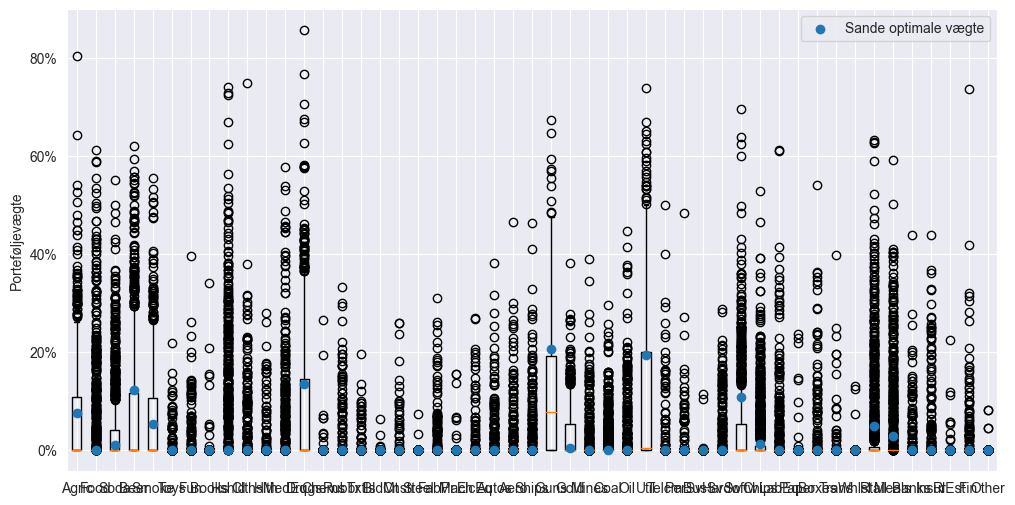

In [294]:
# boxplot of simulated optimal portfolio weights (only for portfolios with few assets)

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(w_sim)
ax.scatter(np.arange(1, len(w_max_sr) + 1), w_max_sr, label="Sande optimale vægte", zorder=10)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xticklabels(assets)
ax.set_ylabel("Porteføljevægte")
ax.legend()
# plt.savefig("boxplot_optimal_weights.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [295]:
# calculate ESTIMATED expected portfolio returns, std. and variances for simulated MV portfolios

mu_sim_est = np.ndarray([num_sim])
var_sim_est = np.ndarray([num_sim])

for k in range (num_sim):
    mu_sim_est[k] = portfolio_mean(w_sim[k], mu_est[k])
    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    var_sim_est[k] = portfolio_variance(w_sim[k], cov_mat_est)

std_sim_est = np.sqrt(var_sim_est)

In [296]:
# calculate ACTUAL expected portfolio returns, std. and variance for the simulated MV portfolios

mu_sim = np.ndarray([num_sim])
var_sim = np.ndarray([num_sim])

for k in range (num_sim):
    mu_sim[k] = portfolio_mean(w_sim[k], mu)
    var_sim[k] = portfolio_variance(w_sim[k], cov_mat)

std_sim = np.sqrt(var_sim)

In [297]:
# calculate ESTIMATED expected portfolio returns, std. and variance for optimal portfolio on simulated returns

mu_opt_sim = np.ndarray([num_sim])
var_opt_sim = np.ndarray([num_sim])

for k in range(num_sim):
    mu_opt_sim[k] = portfolio_mean(w_max_sr, mu_est[k])
    cov_mat_est = np.cov(sim_returns[k], rowvar=False)
    var_opt_sim[k] = portfolio_variance(w_max_sr, cov_mat_est)

std_opt_sim = np.sqrt(var_opt_sim)

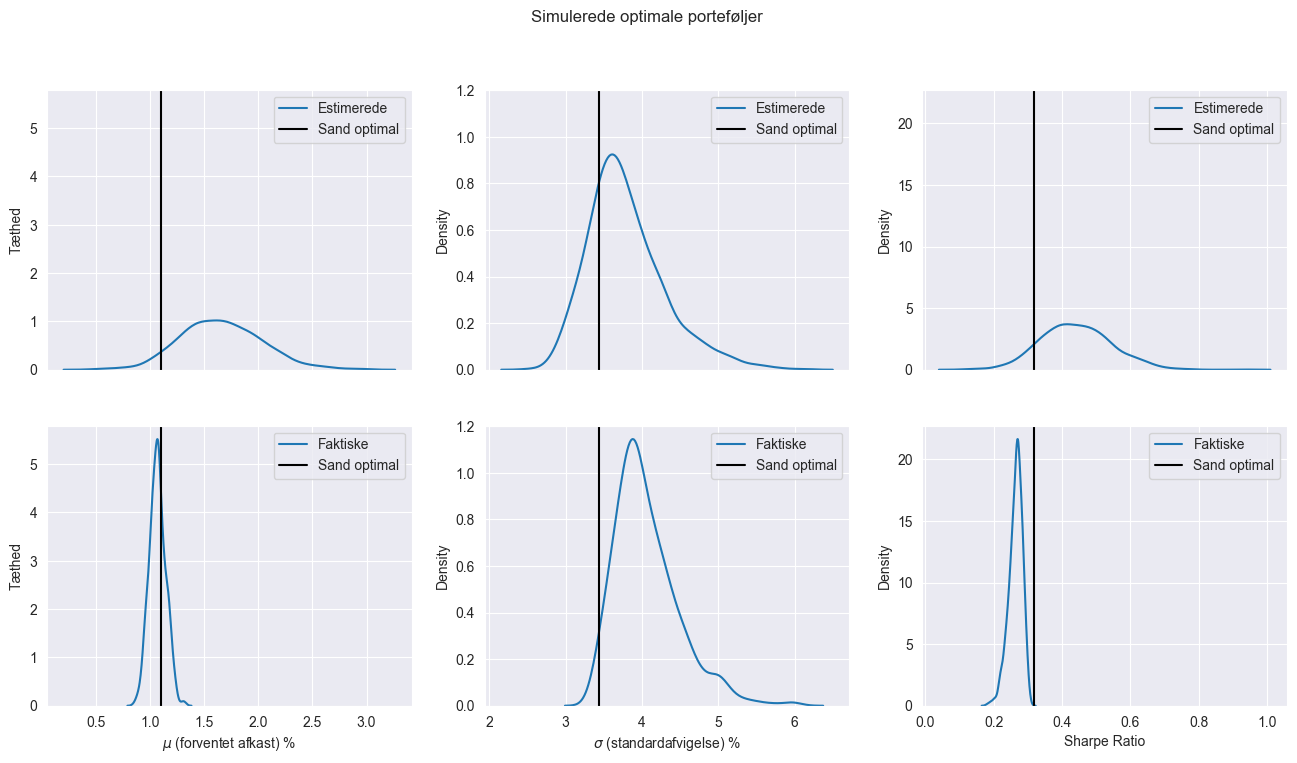

In [298]:
# kde plots for simulerede optimale porteføljer (estimerede og faktiske porteføljevariable)

fig, ax = plt.subplots(2,3,figsize=(16,8), sharex='col', sharey='col')
fig.suptitle('Simulerede optimale porteføljer')

# expected return
sns.kdeplot(mu_sim_est, label="Estimerede", ax=ax[0,0])
sns.kdeplot(mu_sim, label="Faktiske", ax=ax[1,0])
ax[0,0].axvline(mu_max_sr, ymin=0, color="black", label='Sand optimal')
ax[1,0].axvline(mu_max_sr, ymin=0, color="black", label='Sand optimal')
ax[0,0].legend()
ax[1,0].legend()

# std.
sns.kdeplot(std_sim_est, label="Estimerede", ax=ax[0,1])
sns.kdeplot(std_sim, label="Faktiske", ax=ax[1,1])
ax[0,1].axvline(std_max_sr, ymin=0, color="black", label='Sand optimal')
ax[1,1].axvline(std_max_sr, ymin=0, color="black", label='Sand optimal')
ax[0,1].legend()
ax[1,1].legend()

# Sharpe Ratio
sns.kdeplot(mu_sim_est/std_sim_est, label="Estimerede", ax=ax[0,2])
sns.kdeplot(mu_sim/std_sim, label="Faktiske", ax=ax[1,2])
ax[0,2].axvline(sr_max_sr, ymin=0, color="black", label='Sand optimal')
ax[1,2].axvline(sr_max_sr, ymin=0, color="black", label='Sand optimal')
ax[0,2].legend()
ax[1,2].legend()

# labels and ticks
ax[0,0].set_ylabel("Tæthed")
ax[1,0].set_ylabel("Tæthed")
ax[1,0].set_xlabel("$\mu$ (forventet afkast) %")
ax[1,1].set_xlabel("$\sigma$ (standardafvigelse) %")
ax[1,2].set_xlabel("Sharpe Ratio")

# plt.savefig("simulated_optimal_kdplots.jpg",bbox_inches="tight",dpi=300)
plt.show()

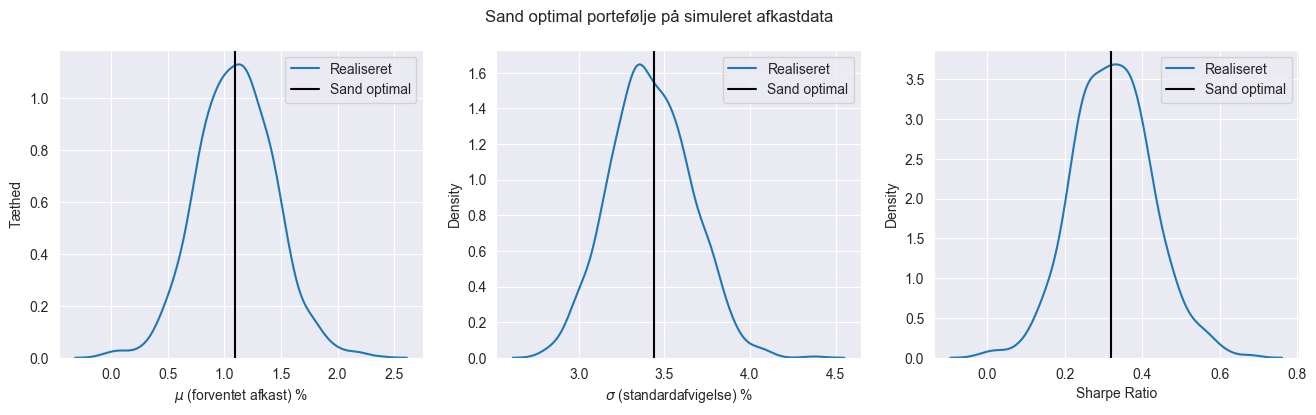

In [299]:
# kde plots for den sande optimale portefølje (på simuleret data)

fig, ax = plt.subplots(1,3,figsize=(16,4), sharex='col', sharey='col')
fig.suptitle('Sand optimal portefølje på simuleret afkastdata')

# expected return
sns.kdeplot(mu_opt_sim, label="Realiseret", ax=ax[0])
ax[0].axvline(mu_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0].legend()

# std.
sns.kdeplot(std_opt_sim, label="Realiseret", ax=ax[1])
ax[1].axvline(std_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1].legend()

# Sharpe Ratio
sns.kdeplot(mu_opt_sim/std_opt_sim, label="Realiseret", ax=ax[2])
ax[2].axvline(sr_max_sr, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[2].legend()

# labels and ticks
ax[0].set_ylabel("Tæthed")
ax[0].set_xlabel("$\mu$ (forventet afkast) %")
ax[1].set_xlabel("$\sigma$ (standardafvigelse) %")
ax[2].set_xlabel("Sharpe Ratio")

# plt.savefig("true_optimal_kdplots.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [300]:
# calculate average of estimated return, variance, std. and SR for simulated MV portfolios

av_mu_sim_est = np.mean(mu_sim_est)
print(av_mu_sim_est)
av_var_sim_est = np.mean(var_sim_est)
print(av_var_sim_est)
av_std_sim_est = np.mean(std_sim_est)
print(av_std_sim_est)
sr_sim_est = np.mean((av_mu_sim_est - rf)/av_std_sim_est)  # skal denne være SR af gennemsnitlige værdier eller gennemsnittet af sharperatios for hver?
print(sr_sim_est)

1.6594367792815965
14.639924698230166
3.792297654655422
0.43758083631554423


In [301]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim = np.mean(mu_sim)
print(av_mu_sim)
av_var_sim = np.mean(var_sim)
print(av_var_sim)
av_std_sim = np.mean(std_sim)
print(av_std_sim)
sr_sim = np.mean((av_mu_sim - rf)/av_std_sim)  # samme spørgsmål her som ovenfor
print(sr_sim)

1.0678257508640854
16.68550440630525
4.062609400378904
0.26284233743083774


In [302]:
# calculate average of simulated return, variance and SR for true optimal portfolio

av_mu_opt_sim = np.mean(mu_opt_sim)
print(av_mu_opt_sim)
av_var_opt_sim = np.mean(var_opt_sim)
print(av_var_opt_sim)
av_std_opt_sim = np.mean(std_opt_sim)
print(av_std_opt_sim)
sr_opt_sim = np.mean((av_mu_opt_sim - rf)/av_std_opt_sim)  # samme spørgsmål her som ovenfor
print(sr_opt_sim)

1.1018000024473376
11.748065387077544
3.41957889175324
0.3222034166559139


In [303]:
sr_max_sr  # lidt lavere end simuleret, prøv med T=1000 og se om det giver det samme

0.3194609605118635

In [304]:
# calculate true expected return, std., variance and SR for an equally weighted portfolio

equal_weights = np.repeat(1/num_assets, num_assets)

mu_eq_port = portfolio_mean(equal_weights, mu)
print(mu_eq_port)
var_eq_port = portfolio_variance(equal_weights, cov_mat)
print(var_eq_port)
std_eq_port = portfolio_std(equal_weights, cov_mat)
print(std_eq_port)
sr_eq_port = sharpe_ratio(mu_eq_port, var_eq_port, 0)
print(sr_eq_port)

1.0218388550225286
21.14253767722199
4.598101529677438
0.22223059852578153


# Plot results in graph with true efficient frontier

In [305]:
# calculate minimum variance portfolio

w_min_var = calculate_min_var_portfolio(cov_mat)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.949863107613261
            Iterations: 17
            Function evaluations: 862
            Gradient evaluations: 17


In [307]:
print(np.round(w_min_var,4))

[0.0522 0.1511 0.     0.     0.     0.     0.     0.     0.1711 0.
 0.     0.     0.1185 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.063  0.0378 0.     0.     0.
 0.3114 0.0159 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.079  0.     0.     0.     0.     0.     0.    ]


In [308]:
mu_min_var = portfolio_mean(w_min_var, mu)
std_min_var = portfolio_std(w_min_var, cov_mat)

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_min_var[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, cov_mat)
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, mu)

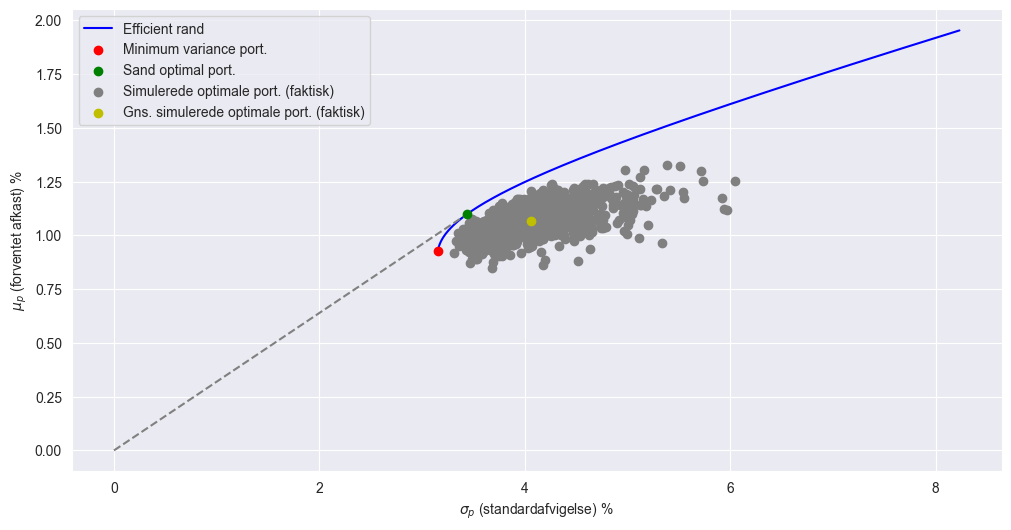

In [309]:
"""
Plot the efficient frontier
"""
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient rand")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_min_var, mu_min_var, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Sand optimal port. ", zorder=10)
#ax.scatter(av_std_sim_est, av_mu_sim_est, color="black", label="Gns. simulerede optimale port. (estimeret)")
ax.scatter(std_sim, mu_sim, color="grey", label="Simulerede optimale port. (faktisk)")
ax.scatter(av_std_sim, av_mu_sim, color="y", label="Gns. simulerede optimale port. (faktisk)", zorder=10)
#ax.scatter(0, rf, color="y", label="Risikofrit afkast", zorder=10)

ax.set_xlabel("$\sigma_p$ (standardafvigelse) %")
ax.set_ylabel("$\mu_p$ (forventet afkast) %")

ax.legend();

# Print tables to Latex

In [312]:
a2l.to_ltx(pd.DataFrame(assets).T, arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.array(mu), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.tril(cov_mat), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(w_max_sr, frmt = '{:6.3f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
 0 &  Agric &  Food &  Soda &  Beer &  Smoke &  Toys &  Fun &  Books &  Hshld &  Clths &  Hlth &  MedEq &  Drugs &  Chems &  Rubbr &  Txtls &  BldMt &  Cnstr &  Steel &  FabPr &  Mach &  ElcEq &  Autos &  Aero &  Ships &  Guns &  Gold &  Mines &  Coal &  Oil &  Util &  Telcm &  PerSv &  BusSv &  Hardw &  Softw &  Chips &  LabEq &  Paper &  Boxes &  Trans &  Whlsl &  Rtail &  Meals &  Banks &  Insur &  RlEst &  Fin &  Other
\end{bmatrix}
\begin{bmatrix}
    1.10 &    0.85 &    1.15 &    1.01 &    1.10 &    0.71 &    1.19 &    0.74 &    0.91 &    1.11 &    0.82 &    1.09 &    1.02 &    0.99 &    1.08 &    0.84 &    1.07 &    1.09 &    0.96 &    0.82 &    1.15 &    1.19 &    1.16 &    1.22 &    1.28 &    1.28 &    0.69 &    1.23 &    1.20 &    1.01 &    0.84 &    0.72 &    0.73 &    0.97 &    1.16 &    1.36 &    1.44 &    1.24 &    0.75 &    0.95 &    0.97 &    0.91 &    1.08 &    1.14 &    1.07 &    1.10 &    0.78 &    1.32 &    0.46
\end{bmatrix}
\begin{bmatrix}
   38.78

# Principal komponentporteføljer

In [313]:
def eig_decomp(corr_mat):
    D, V = np.linalg.eig(corr_mat)
    # sort eigenvalues and eigenvector in decending order
    idx = D.argsort()[::-1]
    D = D[idx]
    V = V[:,idx]
    D = np.diag(D)

    # control sign of eigenvectors (multiply by sign of the sum of all elements, to make sum > 0)
    V *= np.sign(np.sum(V, axis=0))

    return V, D

In [314]:
def calculate_mu_and_var_pc(mu, cov_mat):

    # decompose covariance matrix
    corr_mat, vols_mat = cov_to_corr_and_vols(cov_mat)

    # eigenvalue decomposition of correlationmatrix
    V, D = eig_decomp(corr_mat)

    # calculate expected returns and vols for principalcomponent portfolios
    mu_V = V.T @ np.linalg.inv(vols_mat) @ mu
    std_V = np.diag(np.sqrt(D))

    return mu_V, std_V

In [315]:
# function that calculates risk-contributions (std) of portfolio
def calculate_risk_contributions_std(weights: np.ndarray, cov_matrix: np.ndarray, scale: bool=False) -> np.ndarray:

    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_matrix:
        Covariance matrix

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights
    mr = inner_derivative/total_risk

    if scale:
        mr /= np.sqrt(weights @ cov_matrix @ weights)

    return weights * mr

In [316]:
# calculate principal component portfolios

# true parameters
corr_mat, vols_mat = cov_to_corr_and_vols(cov_mat)
V, D = eig_decomp(corr_mat)
mu_v, std_v = calculate_mu_and_var_pc(mu, cov_mat)
sr_v = mu_v / std_v

# true optimal weights expressed in principal components space
x_v = V.T @ vols_mat @ w_max_sr
risk_contributions = calculate_risk_contributions_std(x_v, D, scale=False)
sharpe_contributions = x_v * (mu_v / np.sqrt(x_v @ D @ x_v))

# initiate variables
mu_v_sim = np.zeros((num_sim, num_assets))
std_v_sim = np.zeros((num_sim, num_assets))
x_v_sim = np.zeros((num_sim, num_assets))
risk_contributions_sim = np.zeros((num_sim, num_assets))  # risk_contributions measured in true V-space
sharpe_contributions_sim = np.zeros((num_sim, num_assets))  # sharpe contributions measured in true V-space

mu_est = np.mean(sim_returns, axis=1)

for k in range(num_sim):
    cov_mat_est = np.cov(sim_returns[k],bias=False, rowvar=False)
    #corr_mat_est, vols_mat_est = cov_to_corr_and_vols(cov_mat_est)
    mu_v_sim[k,:], std_v_sim[k,:] = calculate_mu_and_var_pc(mu_est[k],cov_mat_est)
    x_v_sim[k,:] = V.T @ vols_mat @ w_sim[k,:]
    risk_contributions_sim[k,:] = calculate_risk_contributions_std(x_v_sim[k,:], D, scale=False)
    sharpe_contributions_sim[k,:] = x_v_sim[k,:] * (mu_v / np.sqrt(x_v_sim[k,:] @ D @ x_v_sim[k,:]))

av_mu_v_sim = np.mean(mu_v_sim, axis=0)
av_std_v_sim = np.mean(std_v_sim, axis=0)
av_sr_sim = np.mean(mu_v_sim/std_v_sim, axis=0)
av_risk_contributions_sim = np.mean(risk_contributions_sim, axis=0)
av_sharpe_contributions_sim = np.mean(sharpe_contributions_sim, axis=0)

In [317]:
print(std_max_sr)
np.sum(risk_contributions)

3.4369804055510147


3.436980405551018

In [318]:
print(av_std_sim)
np.sum(av_risk_contributions_sim)

4.062609400378904


4.0626094003789115

In [319]:
print(sr_max_sr)
np.sum(sharpe_contributions)

0.3194609605118635


0.3194609605118639

In [320]:
print(sr_sim)
np.sum(av_sharpe_contributions_sim)

0.26284233743083774


0.26434995329620264

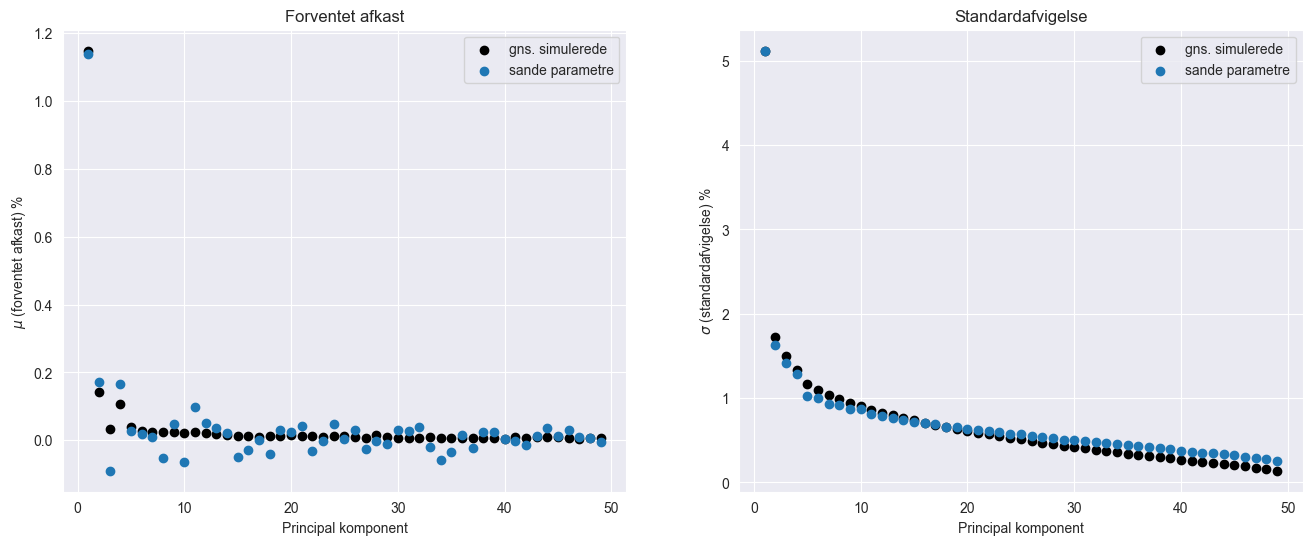

In [328]:
# plot average expected return and std. for each simulated principal components, and the true principal components
principal_components = np.linspace(1,num_assets,num_assets)

fig, ax = plt.subplots(1, 2,figsize=(16,6))

ax[0].scatter(principal_components, av_mu_v_sim, color='black', label='gns. simulerede')
ax[0].scatter(principal_components, mu_v, label='sande parametre')

ax[1].scatter(principal_components, av_std_v_sim, color='black', label='gns. simulerede')
ax[1].scatter(principal_components, std_v, label='sande parametre')

ax[0].title.set_text('Forventet afkast')
ax[0].set_ylabel("$\mu$ (forventet afkast) %")
ax[0].set_xlabel("Principal komponent")
ax[1].title.set_text('Standardafvigelse')
ax[1].set_ylabel('$\sigma$ (standardafvigelse) %')
ax[1].set_xlabel("Principal komponent")
ax[0].legend(); ax[1].legend()

plt.savefig("expected_return_and_std_for_PPs.jpg",bbox_inches="tight",dpi=300)
plt.show()

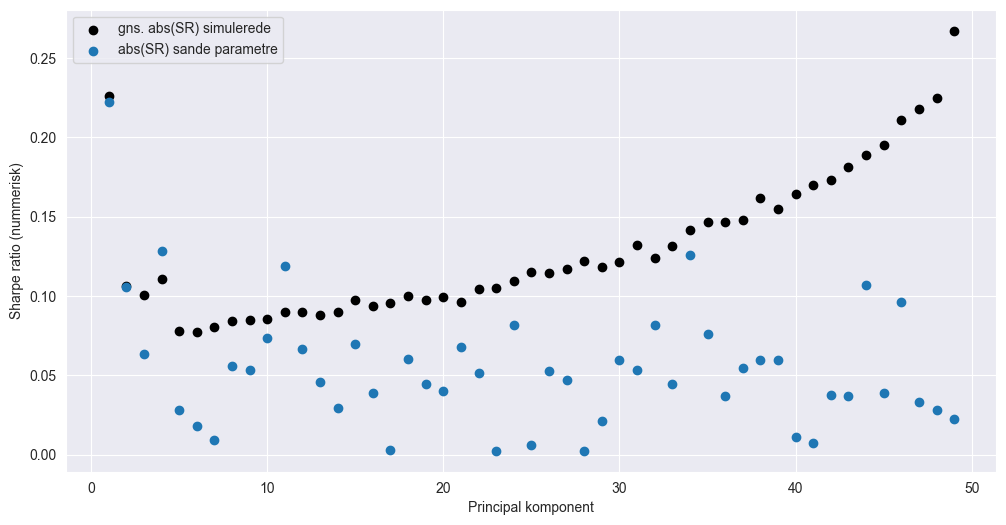

In [331]:
# plot average absolute SR for each simulated principal components, and the true principal components

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(principal_components, np.mean(np.abs(mu_v_sim/std_v_sim), axis=0), color='black', label='gns. abs(SR) simulerede')
ax.scatter(principal_components, np.abs(sr_v), label='abs(SR) sande parametre')

ax.set_ylabel("Sharpe ratio (nummerisk)")
ax.set_xlabel("Principal komponent")

ax.legend()

plt.savefig("absolute_SR_for_PPs.jpg",bbox_inches="tight",dpi=300)
plt.show()

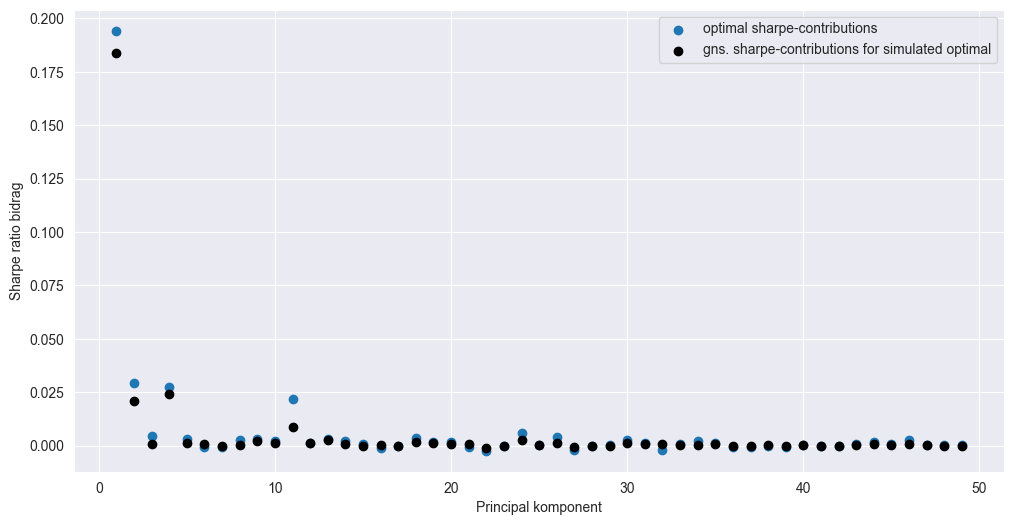

In [332]:
# plot Sharpe ratio contributions for each of the simulated principal components, and the true principal components

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(principal_components[:], sharpe_contributions, label='optimal sharpe-contributions')
ax.scatter(principal_components[:], av_sharpe_contributions_sim, color='black', label='gns. sharpe-contributions for simulated optimal')

ax.set_ylabel("Sharpe ratio bidrag")
ax.set_xlabel("Principal komponent")

ax.legend()

plt.savefig("SR_contributions_for_PPs.jpg",bbox_inches="tight",dpi=300)
plt.show()

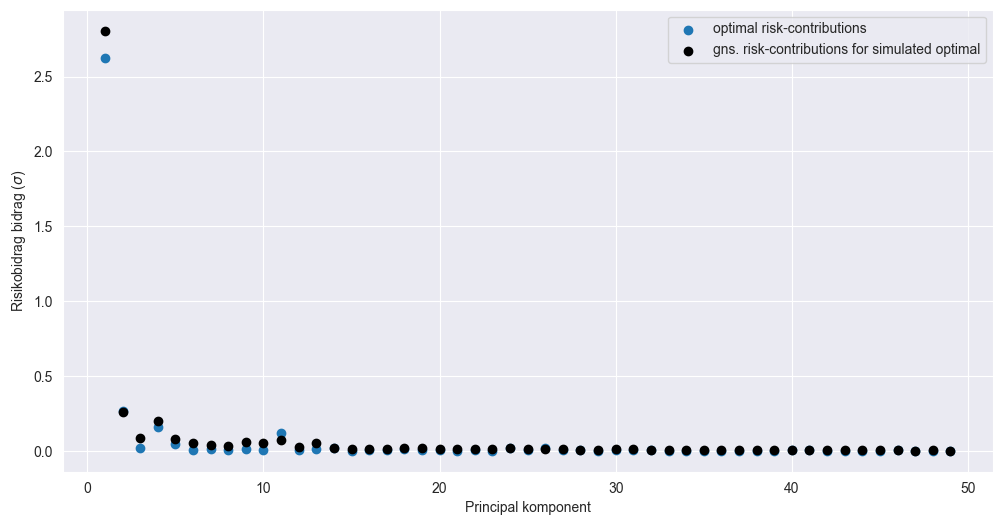

In [334]:
# plot risk contributions for each of the simulated principal components, and the true principal components

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(principal_components[:], risk_contributions, label='optimal risk-contributions')
ax.scatter(principal_components[:], av_risk_contributions_sim, color='black', label='gns. risk-contributions for simulated optimal')

ax.set_ylabel("Risikobidrag bidrag ($\sigma$)")
ax.set_xlabel("Principal komponent")

ax.legend()

plt.savefig("risk_contributions_for_PPs.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [ ]:
""" NOT USED """
# calculate relative sharpe ratio contributions for true optimal portfolio

mr = (D @ x_v) / np.sqrt(x_v @ D @ x_v)
rc = x_v * mr  # sum of this is std of optimal portfolio
diversification_factors = std_v / mr
risk_factors = rc / np.sqrt(x_v @ D @ x_v) # sum of this is 1
pc_sharpe_ratios = mu_v / std_v

(diversification_factors * risk_factors * pc_sharpe_ratios)